# Calibrating Qubits with Qiskit Pulse

Qiskitは、量子コンピュータをプログラミングするためのオープンソースフレームワークです。Qiskitを使用すると、量子デバイスを量子回路で、構築、シミュレーション、実行できます。

Qiskit Pulseは、特定のハードウェア実装に依存しない一般的な量子デバイスのパルスレベル制御(つまり、入力信号の連続時間ダイナミクスの制御)を指定するための言語を提供します。

このチュートリアルでは、Qiskit Pulseを使用して、一般的なシングルキュービットのキャリブレーションと特性評価実験を実装する方法を示します。これらは、通常、デバイスが製造されてシステムにインストールされた直後にラボで行われる最初の実験です。プレゼンテーションは教育的であり、学生は実験的に2レベルのシステムダイナミクスを探索できます。全ての単位は標準SI(つまり、Hz、秒など)として返されます。

各実験により、システムに関するより多くの情報が得られます。これは通常、後続の実験で使用されます。このため、このノートブックはほとんど順番に実行する必要があります。

## Contents
1. Getting Started
2. Finding the qubit Frequency using a Frequency Sweep
3. Calibrating and using a $π$ Pulse<br>
3.1 Calibrating $π$ Pulses using a Rabi Experiment<br>
3.2 Determining 0 vs 2<br>
3.3 Measuring $T_1$ Using Inversion Recovery
4. Determining qubit Coherence<br>
4.1 Measuring the qubit Frequency Precisely using a Ramsey Experiment<br>
4.2 Measuring $T_2$ using Hahn Echoes

## 1. Getting Started

まず、基本的な依存関係(dependencies)を設定して準備を整えます。このノートブックのキャリブレーション実験では、実際のノイズの多いデバイスを使用したいので、IBMQアカウントをロードして適切なバックエンドを設定する必要があります。

In [1]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

バックエンドの構成を確認して、バックエンドがPulse機能をサポートしていることを確認します。configは、バックエンドセットアップの構造に関する一般的な情報を提供します。

In [2]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

例えば、バックエンド構成内のバックエンドパルスのサンプリング時間を見つけることができます。これは、キャリブレーションルーチンを作成して実行するときに非常に役立つ値です。

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


バックエンドのデフォルトは、バックエンドの使用方法の開始点を提供します。基本的な量子演算子を制定するためのqubit周波数とデフォルトプログラムの推定値が含まれています。次の方法でアクセスすることができます。

In [4]:
backend_defaults = backend.defaults()

## 2.Finding the qubit Frequency using a Frequency Sweep

まず、qubit周波数(qubit frequency)を検索します。qubit周波数は、基底状態と励起状態(ground and excited states)の間のエネルギーの差であり、それぞれ|0>と|1>の状態を示します。この周波数は、qubitで特定の量子演算子を実行するパルスを作成するために重要になります。キャリブレーションの最終目標です！

超電導qubits(superconducting qubits)を使用すると、より高いエネルギーレベルも利用できますが、システムを非調和的に製造して、励起する遷移を制御できるようにします。このようにして、2つのエネルギーレベルを分離し、各qubitを基本的な2レベルシステムとして扱い、より高いエネルギー状態を無視することができます。

典型的なラボ設定では、ネットワークアナライザー(Network Analyzer)と呼ばれるツールを使用して周波数の範囲を掃引(sweep)し、吸収の兆候を探すことにより、qubit周波数を見つけることができます。この測定により、qubit周波数の概算が得られます。後で、ラムジーパルスシーケンス(Ramsey pulse sequence)を使用してより正確な測定を行う方法について説明します。

まず、qubitを探す際に掃引される周波数範囲を定義します。これは任意に広げることができるため、backend_defaultsで推定されたqubit周波数の周囲の40MHzのウィンドウに制限します。1MHz単位で周波数をステップします。

In [5]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974444298251948 GHz.
The sweep will go from 4.954444298251947 GHz to 4.994444298251947 GHz in steps of 1.0 MHz.


次に、実験に使用するパルスを定義します。ガウスパルスである駆動パルス　(drive pulse)から始めます。

以前扱った値$dt$を覚えていますか？パルスの全ての期間は$dt$で与えられます。次のセルでは、駆動パルスの長さをdtで定義します。

In [6]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [7]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

qubitを適切に測定するには、測定マップを確認する必要があります。これはハードウェアの制約です。取得が1つのqubitに対して行われると、他のqubitに対しても行われます。Pulseでプログラムを構築するときは、この制約を尊重する必要があります。私たちのqubitが入っているqubitのグループをチェックしましょう。

In [8]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

これで、測定パルスを定義できます。パルスをハードコーディングするのではなく、バックエンドのデフォルトの命令スケジュールマップ(instruction schedule map)からキャリブレーションされた測定パルスを取得できます。頻繁にキャリブレーションされるため、測定パルスを自分で定義するよりも正確です。この測定パルスにはacquisitionも含まれるため、手動で追加する必要はありません。

In [9]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

最後に、パルスを適用するチャネルを指定します。駆動、測定、及び取得チャネルは、qubitインデックスによってインデックス化されます。

In [10]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

パルスパラメータが定義され、実験用のパルス形状が作成されたので、パルススケジュールの作成に進むことができます。

各周波数で、その周波数の駆動パルスをqubitに送信し、パルスの直後に測定します。パルスエンベロープは周波数に依存しないため、再利用可能なスケジュールを作成し、周波数構成配列(frequency configuration array)で駆動パルス周波数を指定します。

In [11]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

健全性チェックとして、常にパルススケジュールを確認することをお勧めします。これは、以下に示すように、schedule.draw()を使用して行うことができます。

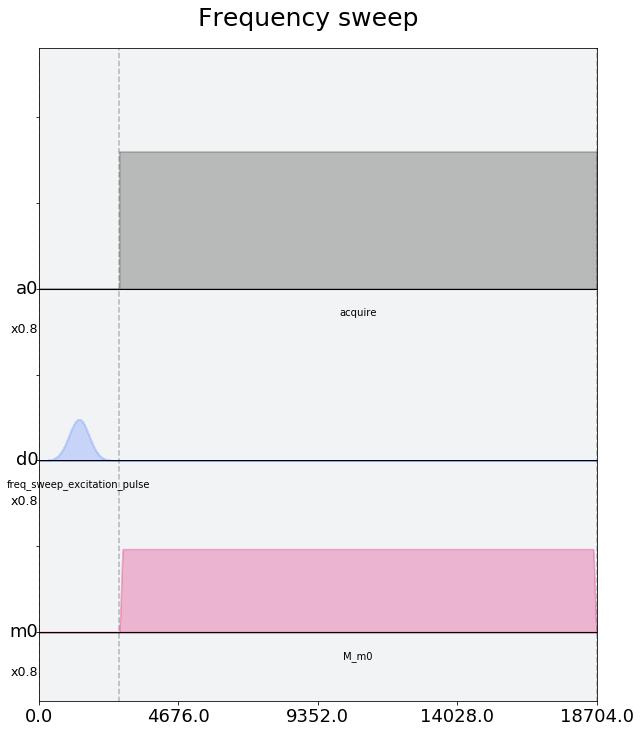

In [12]:
schedule.draw(label=True, scaling=0.8)

上記のスケジュールとschedule_frequenciesを、"Qobj"と呼ばれるプログラムオブジェクトにアセンブルします。これは、量子デバイスに送信できます。qubit応答の適切な推定値を取得するために、各スケジュール(周波数スイープの各ポイント)をnum_shots_per_frequency回繰り返すように要求します。

測定設定も指定します。meas_level = 0は生データ(ショットごとの複素数値の配列)を返し、meas_level = 1はカーネルデータ(ショットごとに1つの複素数値)を返し、meas_level = 2は分類されたデータ(ショットごとに0または1ビット)を返します。ラボにいて、0と1を分類するための弁別器をまだキャリブレーションしていない場合に、私たちが作業しているものを複製するために、meas_level = 1を選択します。個々のショットではなく、結果の「平均」を求めます。

In [13]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

さらに別のユニット変更警告が表示される場合がありますが、これは無視して構いません。最後に、以下を使用してアセンブルされたプログラムをバックエンドで実行できます。

In [15]:
job = backend.run(frequency_sweep_program)

後で取得するためにjob_idを出力し、job_monitor()を使用してジョブのステータスを監視することを常にお勧めします。

In [16]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


ジョブが実行されると、次を使用して結果を取得できます。

In [17]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

結果を抽出し、matplotlibを使用してプロットします。

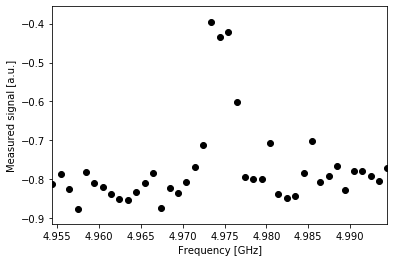

In [18]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

上記のように、中心付近のピークはqubit周波数の位置に対応しています。信号はパワーブロードニング(power-broadening)を示しています。これは、中心周波数に近づくと、qubitを非共振(off-resonance)に駆動できることを示しています。ピーク周波数の値を取得するために、値を共鳴応答曲線(resonance response curve)に適合させます。これは通常、ローレンツ(Lorentzian)の形状です。

In [19]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [20]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [5, 4.975, 1, 3] # initial parameters for curve_fit
                                )

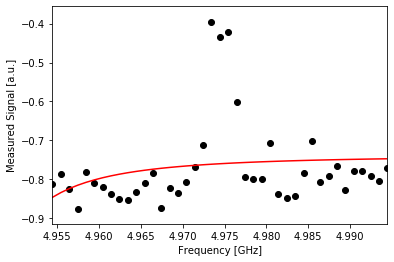

In [21]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [22]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97444 GHz to 4.93813 GHz.


## 3. Calibrating and using a $π$ Pulse

### 3.1 Calibrating $π$ Pulses using a Rabi Experiment

qubitの周波数がわかったら、次のステップは、$π$パルスの強度を決定することです。qubitを2レベルのシステムとして厳密に言うと、$π$パルスは、qubitを|0>から|1>に、またはその逆に取るものです。これは、$X$または$X180$ゲート
、またはビットフリップ演算子とも呼ばれます。前の周波数掃引実験からの遷移を駆動するために必要なマイクロ波周波数は既にわかっているため、|0>から|1>への$π$回転を実現するために必要な振幅を求めます。望ましい回転は、下の図のブロッホ球に示されています。$π$パルスは、ブロッホ球をスイープする角度から名前が付けられていることがわかります。

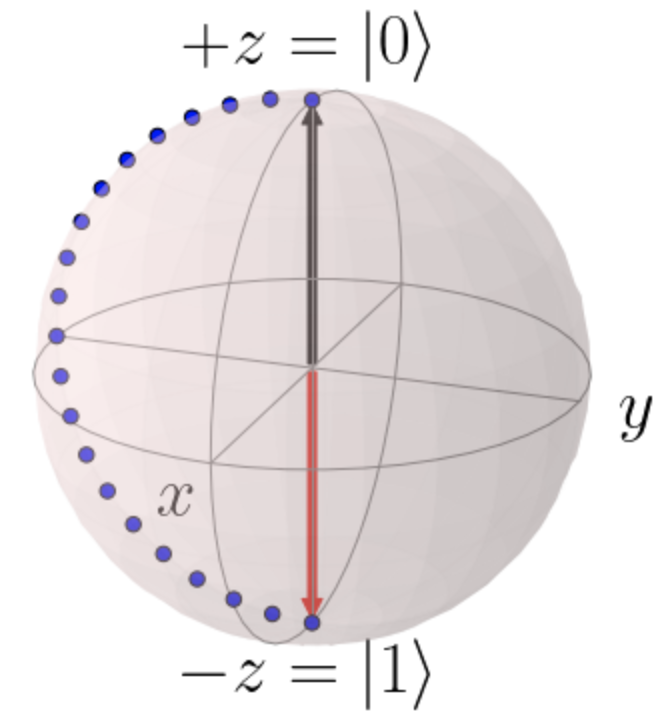

ドライブの振幅を少しずつ変化させ、qubitの状態を毎回測定します。qubitが|0>から|1>に、またその逆に戻るときに、ラビ振動(Rabi oscillations)と一般的に呼ばれる振動が見られると予想しています。

In [24]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [25]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

スケジュールは基本的に周波数掃引実験と同じに見えます。唯一の違いは、変調周波数(modulation frequency)ではなく駆動パルスの振幅を変化させる一連の実験を実行していることです。

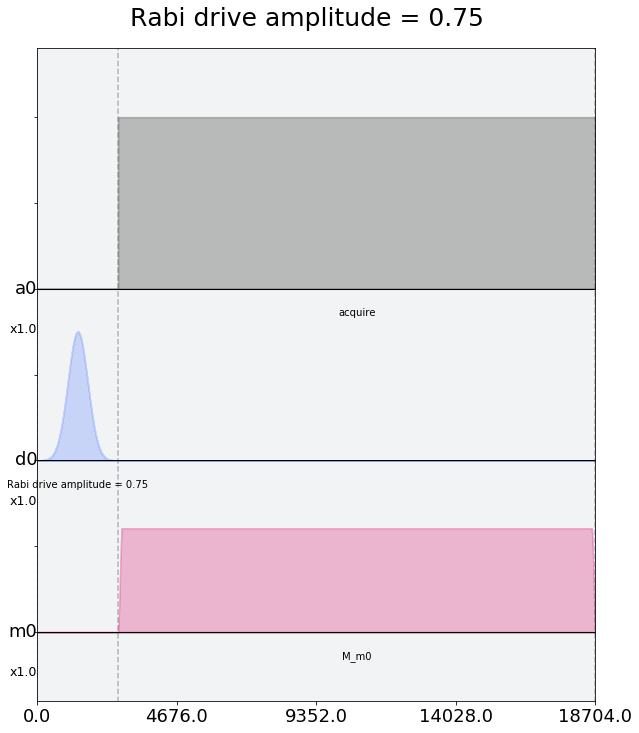

In [26]:
rabi_schedules[-1].draw(label=True, scaling=1.0)

In [27]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [30]:
# print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

Job Status: job has successfully run


In [31]:
rabi_results = job.result(timeout=120)

結果が得られたので、それらを抽出し、正弦曲線に適合させます。選択した駆動振幅の範囲では、|0>から始めて、qubitをブロッホ球の周りで完全に数回回転させると予想しています。この正弦波の振幅は、|1>状態を生成したRabiドライブの振幅でのショットの割合を示します。信号が最大(すべて|0>の状態)から最小(すべて|1>の状態)に振動するために必要な駆動振幅を求めます。これにより$π$パルスを実行するキャリブレーションされた振幅が得られます。

In [32]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

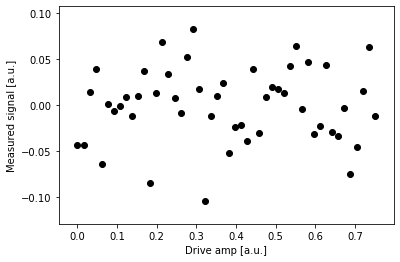

In [33]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

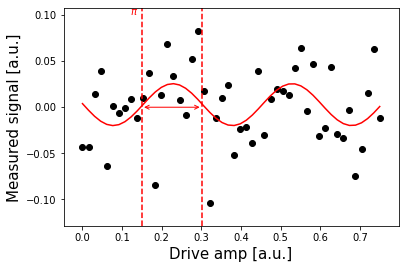

In [34]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [35]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.15040930412134515


#### Our $π$ pulse !

先ほど見つけた振幅でパルスを定義して、後の実験で使用できるようにします。

In [36]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')

### 3.2 Determining 0 vs 1

$π$パルスが調整されたら、適切な確率で状態|1>を作成できます。これを使用して、|0>と|1>の状態を繰り返し測定し、測定された信号をプロットすることにより、測定でどのように見えるかを確認できます。これは、弁別器を構築するために使用するものです。これは、測定されカーネル化された複素数値(meas_level = 1)を受け取り、それを0または1(meas_level = 2)として分類する関数です。

In [37]:
# Create two schedules

# Ground state schedule
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

# Excited state schedule
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(pi_pulse, drive_chan)  # We found this in Part 2A above
exc_schedule += measure << exc_schedule.duration

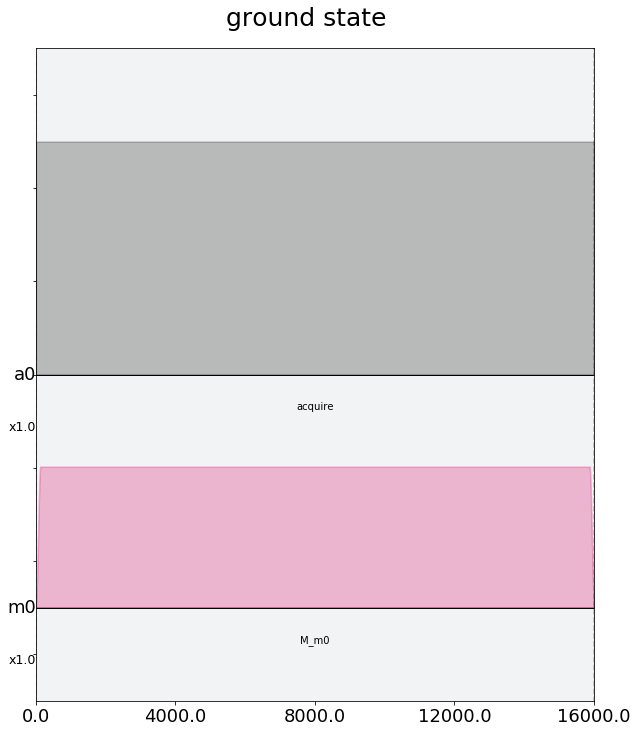

In [38]:
gnd_schedule.draw(label=True, scaling=1.0)

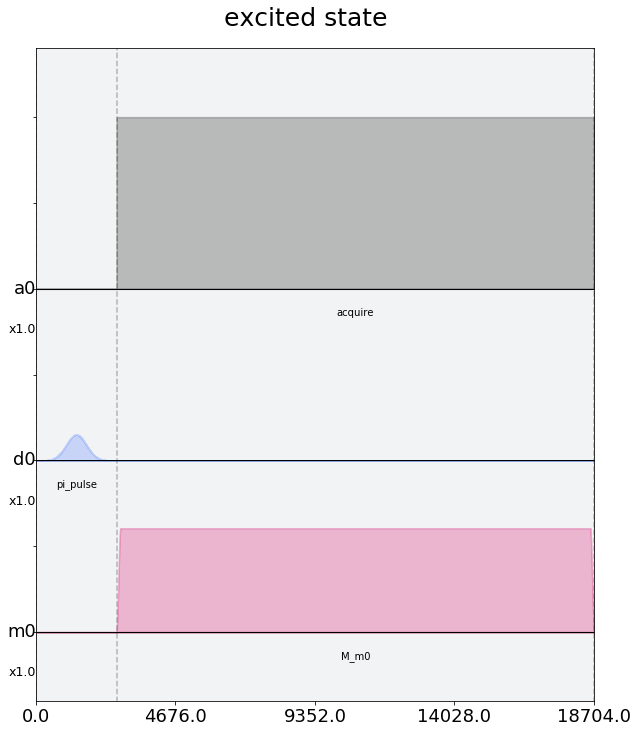

In [39]:
exc_schedule.draw(label=True, scaling=1.0)

基底と励起状態の準備スケジュール(preparation schedules)を1つのQobjにまとめます。これらはそれぞれnum_shots回実行されます。今回は、結果が|0>または|1>に分類されていないため、今回はmeas_level = 1を選択します。代わりに、カーネル化されたデータが必要です。つまり、カーネル関数(kernel function)を通過してショットごとに1つの複雑な値を生成した生の取得データです。(カーネルは、生の測定データに適用されるドット積と考えることができます。)exc_scheduleでのみ使用されますが、両方のスケジュールに同じ頻度を渡します。

In [40]:
# Execution settings
num_shots = 1024

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

In [41]:
# print(job.job_id())
job = backend.run(gnd_exc_program)
job_monitor(job)

Job Status: job has successfully run


In [42]:
gnd_exc_results = job.result(timeout=120)

これで結果が得られたので、準備した2つの母集団を単純な散布図で視覚化できます。基底状態プログラムの結果は青で、励起状態の準備プログラムの結果は赤で表示されます。<br>
注：母集団が不規則な形状(ほぼ円形ではない)の場合は、ノートブックを再実行してみてください。

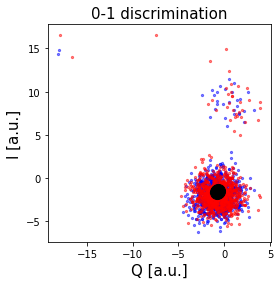

In [43]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

|0>と|1>の2つの集団が独自のクラスターを形成していることがはっきりとわかります。カーネル化された測定結果(meas_level = 1)からは、これら2つのクラスターを最適に分離する弁別子を適用することによって(meas_level = 2)に分類されます。最適な分離は、IQ平面の単純な線であり、大きな点で上にプロットした平均結果から等距離で、2つの点を結ぶ線に垂直です。

特定の点が基底状態の結果の平均に近い場合は0を返し、点が平均励起状態の結果に近い場合は1を返すことにより、迅速な分類関数を設定できます。

In [44]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

### 3.3 Measuring $T_1$ using Inversion Recovery 

qubitの$T_1$時間は、qubitが励起状態から基底状態に減衰するのにかかる時間です。量子コンピュータで実行できる有意義なプログラムの期間を制限するため、これは重要です。

$T_1$の測定は以前の実験と同様であり、キャリブレートした$π$パルスを使用します。もう一度、単一の駆動パルスである$π$パルスを適用し、次に測定パルスを適用します。ただし、今回はすぐには測定を行いません。遅延を挿入し、その遅延を実験間で変化させます。測定された信号を遅延時間に対してプロットすると、qubitがエネルギーで緩和するにつれて、指数関数的に減衰する信号が表示されます。減衰時間はqubitの$T_1$(緩和時間)です。

In [45]:
# T1 experiment parameters
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt
# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [46]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)

$T_1$のスケジュールも確認できます。この実験を実際に理解するには、sched_idxの値を変えて、次のセルを複数回実行して、いくつかのスケジュールを確認してください。sched_idxを増やすと、後で測定パルスが開始するのがわかります。

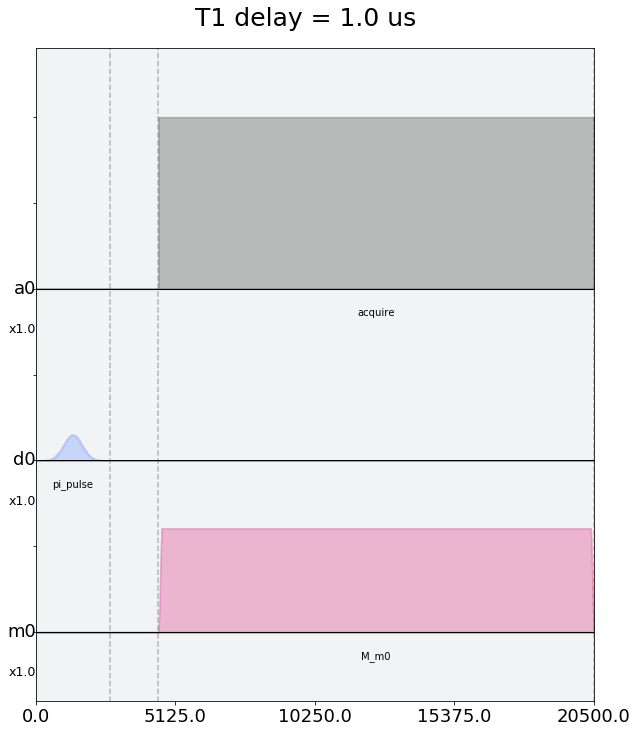

In [47]:
sched_idx = 0
t1_schedules[sched_idx].draw(label=True, scaling=1.0)

In [48]:
# Execution settings
num_shots = 256

t1_experiment = assemble(t1_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_frequency}] * len(t1_schedules))

In [49]:
job = backend.run(t1_experiment)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [50]:
t1_results = job.result(timeout=120)

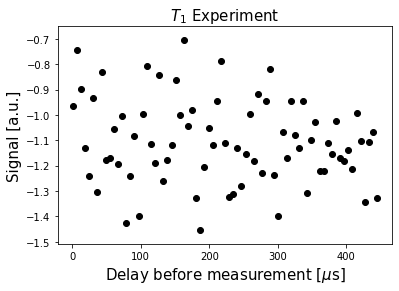

In [51]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

次に、減衰する指数にデータを当てはめると、$T_1$が得られます。

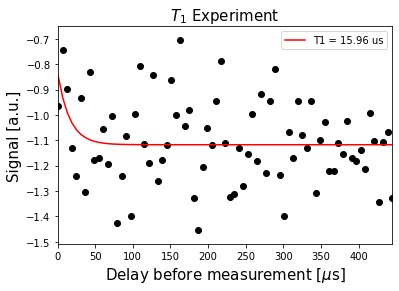

In [52]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

## 4.  Determining qubit  Coherence

### 4.1 Measuring the qubit Frequency Precisely using a Ramsey Experiment

次に、qubit周波数をより正確に決定します。これは、ラムジーパルスシーケンス(Ramsey pulse sequence)を使用して行われます。このパルスシーケンスでは、最初に$\frac{π}{2}$("pi over two")パルスを適用し、しばらく$Δt$待ってから、別の$\frac{π}{2}$パルスを適用します。パルスと同じ周波数でqubitからの信号を測定しているので、印加されたパルスとqubitの間の周波数の差で発振を観察する必要があります。

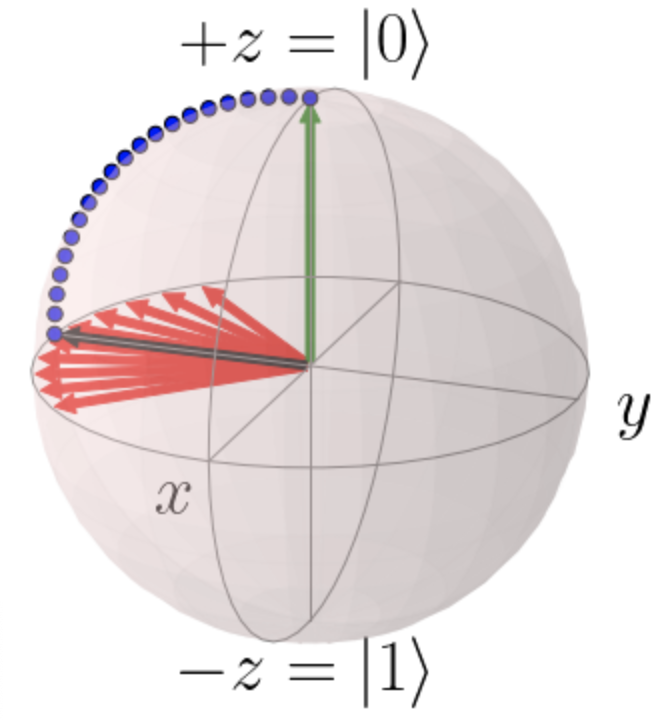

In [53]:
# Ramsey experiment parameters
time_max_us = 1.8
time_step_us = 0.025
times_us = np.arange(0.1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2
# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
x90_pulse = pulse_lib.gaussian(duration=drive_samples,
                               amp=drive_amp, 
                               sigma=drive_sigma,
                               name='x90_pulse')

In [54]:
# create schedules for Ramsey experiment 
ramsey_schedules = []

for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"Ramsey delay = {delay * dt / us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)

    ramsey_schedules.append(this_schedule)

$T_1$スケジュールの場合と同様に、次のセルを複数回実行して、作成したいくつかのスケジュールを検査するのは簡単です。ramsey_schedulesのインデックスの増加を見ると、2つの$\frac{π}{2}$パルス間の遅延が増加します。

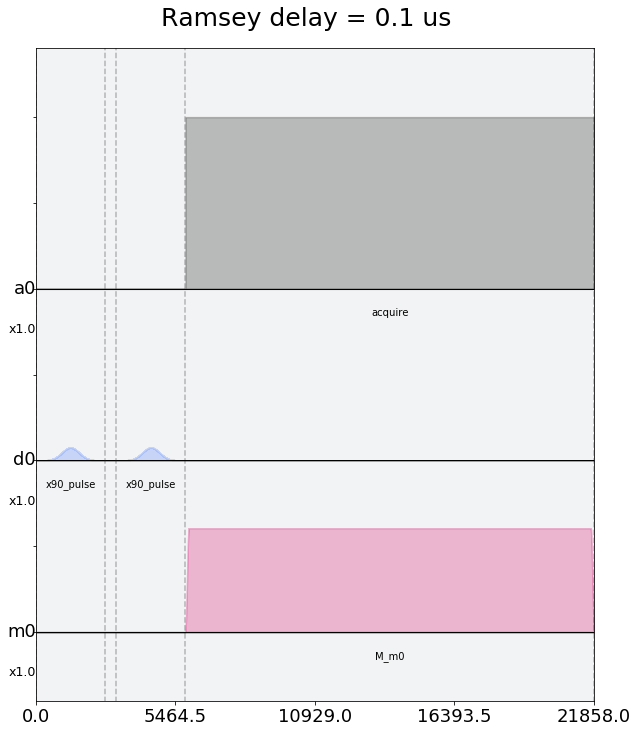

In [55]:
ramsey_schedules[0].draw(label=True, scaling=1.0)

それでは、一般的に使用される実験的なトリックを適用します。既知の量だけパルスを非共振に駆動します。これを、detuning_MHzと呼びます。測定されたラムジー信号は、オフセットが小さく、周波数がdetuning_MHzに近い発振を示すはずです。この小さなオフセットは、rough_qubit_frequencyがqubit周波数からどれだけ離れているかを正確に表しています。

In [56]:
# Execution settings
num_shots = 256

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz
ramsey_program = assemble(ramsey_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots,
                             schedule_los=[{drive_chan: ramsey_frequency}]*len(ramsey_schedules)
                            )

In [57]:
job = backend.run(ramsey_program)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [58]:
ramsey_results = job.result(timeout=120)

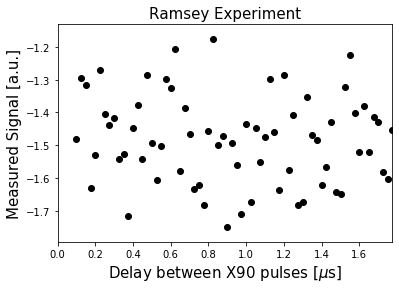

In [59]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results.get_memory(i)[qubit]*scale_factor)
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

データを正弦波に適合させ、関心のある情報、つまり$Δf$を抽出します。

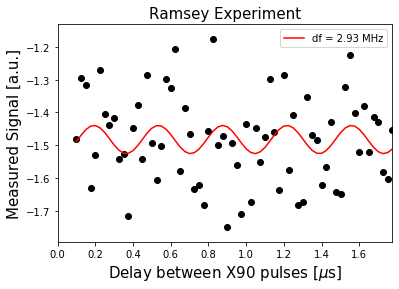

In [60]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

del_f_MHzがわかったので、qubit周波数の推定値を更新できます。

In [61]:
precise_qubit_freq = rough_qubit_frequency + (del_f_MHz - detuning_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 4.939062 GHz. It used to be 4.938132 GHz


### 4.2 Measuring $T_2$ using Hahn Echoes

次に、qubitのコヒーレンス時間$T_2$を測定できます。この実験を行うために使用されるパルスシーケンスは、ハーンエコー(Hahn echo)として知られています。この用語は、NMRコミュニティから来ています。ハーンエコー実験は、上記のラムジー実験と非常によく似ていますが、2つの$\frac{π}{2}$パルスの間に追加の$π$パルスがあります。時間$t$の$π$パルスは位相の累積を反転させ、時間$2t$にエコーを生成します。最後の$\frac{π}{2}$パルスを適用して測定を行います。

ハーンエコー実験の減衰時間は、コヒーレンス時間$T_2$を与えます。

In [62]:
# T2 experiment parameters
tau_max_us = 200
tau_step_us = 4
taus_us = np.arange(2, tau_max_us, tau_step_us)
# Convert to units of dt
delay_times_dt = taus_us * us / dt

# We will use the pi_pulse and x90_pulse from previous experiments

In [63]:
t2_schedules = []
for tau in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T2 delay = {tau *dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= measure << int(this_schedule.duration)
    
    t2_schedules.append(this_schedule)

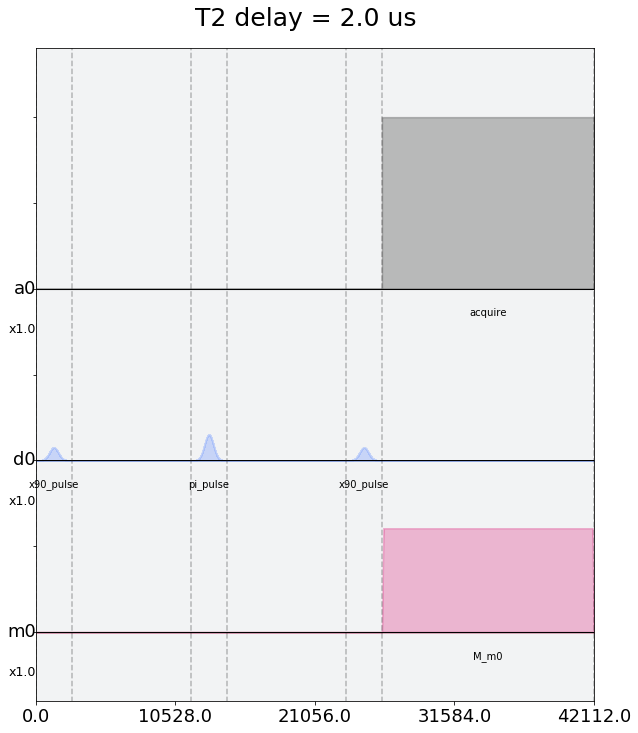

In [64]:
t2_schedules[0].draw(label=True, scaling=1.0)

In [65]:
# Execution settings
num_shots_per_point = 512

t2_experiment = assemble(t2_schedules,
                         backend=backend,
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots_per_point,
                         schedule_los=[{drive_chan: precise_qubit_freq}]
                                      * len(t2_schedules))

In [66]:
job = backend.run(t2_experiment)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [67]:
t2_results = job.result(timeout=120)

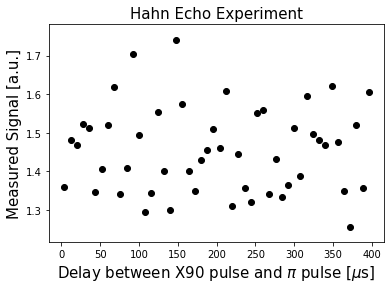

In [68]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results.get_memory(i)[qubit]*scale_factor)

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

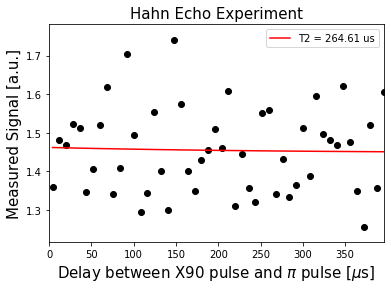

In [69]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

### C. Dynamical decoupling

単一の$π$パルスは、位相累積の逆転に起因する準静的ノイズを除去することができます。この概念は、いくつかの$π$パルスを連続して適用することにより、準静的とは近似できないノイズに拡張できます。この手法は、一般的に動的デカップリングと呼ばれ、様々な周波数のノイズをキャンセルすることができ、qubitからより長いコヒーレンス時間を抽出するために使用されます。

In [70]:
# DD experiment parameters
tau_us_min = 1
tau_us_max = 40
tau_step_us = 1.5
taus_us = np.arange(tau_us_min, tau_us_max, tau_step_us)
# Convert to units of dt
taus_dt = taus_us * us / dt
num_pi_pulses = 6 # apply two pi pulses
print(f"Total time ranges from {2.*num_pi_pulses*taus_us[0]} to {2.*num_pi_pulses*taus_us[-1]} us")

Total time ranges from 12.0 to 462.0 us


In [71]:
T2DD_schedules = []
for delay in taus_dt:
    this_schedule = pulse.Schedule(name=f"T2DD delay = {delay * dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + delay)

    for _ in range(num_pi_pulses - 1):
        this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + 2*delay)

    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)
    
    T2DD_schedules.append(this_schedule)

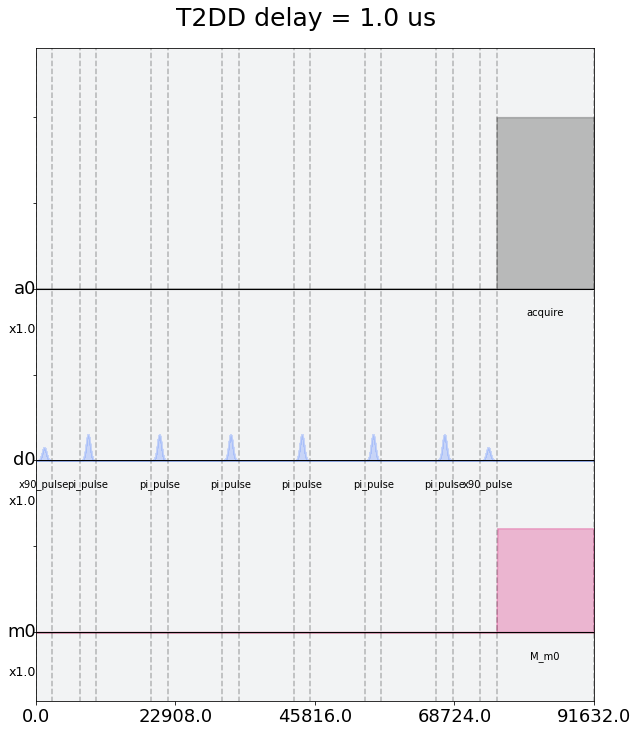

In [72]:
T2DD_schedules[0].draw(label=True, scaling=1.0)

In [73]:
num_shots_per_point = 1024

T2DD_experiment = assemble(T2DD_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots_per_point,
                             schedule_los=[{drive_chan: precise_qubit_freq}]
                                          * len(T2DD_schedules))

In [74]:
job = backend.run(T2DD_experiment)
# print(job.job_id())
job_monitor(job)

Job Status: job has successfully run


In [75]:
T2DD_results = job.result(timeout=120)

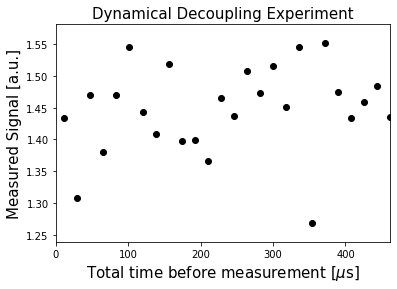

In [76]:
times_us = 2.*num_pi_pulses*taus_us
DD_values = []
for i in range(len(taus_us)):
    DD_values.append(T2DD_results.get_memory(i)[qubit]*scale_factor)

plt.scatter(times_us, np.real(DD_values), color='black')
plt.xlim(0, np.max(times_us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

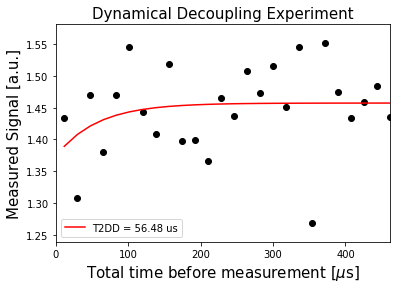

In [77]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_us, np.real(DD_values), [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_us, np.real(DD_values), color='black')
plt.plot(times_us, fit_func(times_us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()